In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import diffrax as dfx
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

In [10]:
time_of_approach_noise = np.load("infer_errors.npy")
time_of_approach_determinsitic = np.load("infer_error_deterministic.npy")

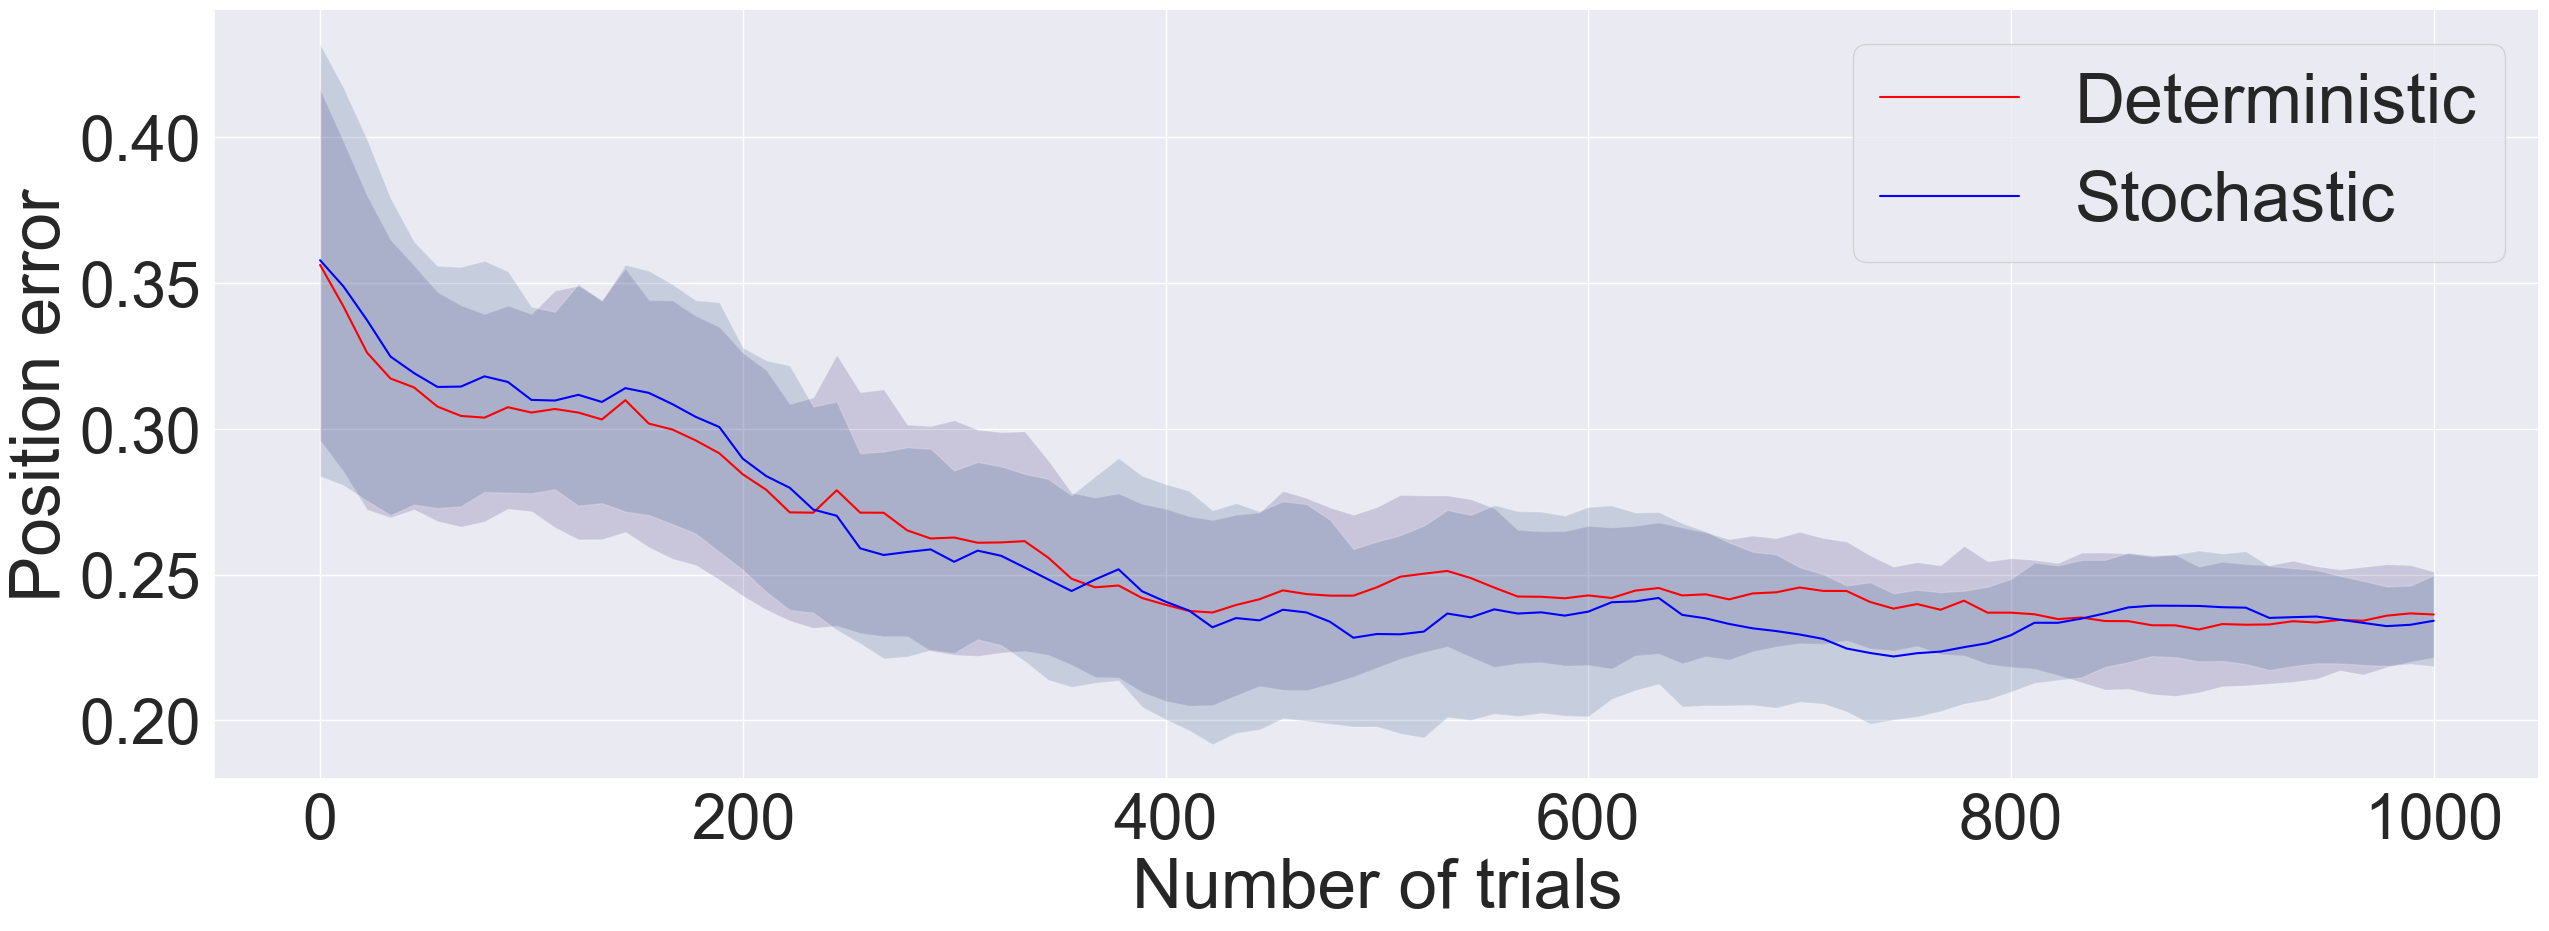

In [24]:
x = np.linspace(0, 1000, 91)
y1_mean = np.mean(time_of_approach_noise, axis=0)
y1_smooth = np.convolve(y1_mean, np.ones(10)/10, mode='valid')
y1_std = np.std(time_of_approach_noise, axis=0)
y1_std = np.convolve(y1_std, np.ones(10)/10, mode='valid')
fig, ax = plt.subplots(figsize=(30,10))

x_d = np.linspace(0, 1000, 91)
y1_mean_d = np.mean(time_of_approach_determinsitic, axis=0)
y1_smooth_d = np.convolve(y1_mean_d, np.ones(10)/10, mode='valid')
y1_std_d = np.std(time_of_approach_determinsitic, axis=0)
y1_std_d = np.convolve(y1_std_d, np.ones(10)/10, mode='valid')

ax.plot(x_d, y1_smooth_d, label="Deterministic", color='red')
ax.fill_between(x_d, y1_smooth_d - y1_std_d, y1_smooth_d + y1_std_d, alpha=0.2)

ax.plot(x, y1_smooth, label="Stochastic", color='blue')
ax.fill_between(x, y1_smooth - y1_std, y1_smooth + y1_std, alpha=0.2)

ax.set_xlabel('Number of trials', fontsize=50)
ax.set_ylabel('Position error', fontsize=50)
#set xticks and yticks size
ax.tick_params(axis='x', labelsize=45)
ax.tick_params(axis='y', labelsize=45)
plt.legend(fontsize=50)
plt.savefig('Dist_error_comp.svg', format='svg', bbox_inches='tight')

plt.show()

In [11]:
data = np.load('values.npy')

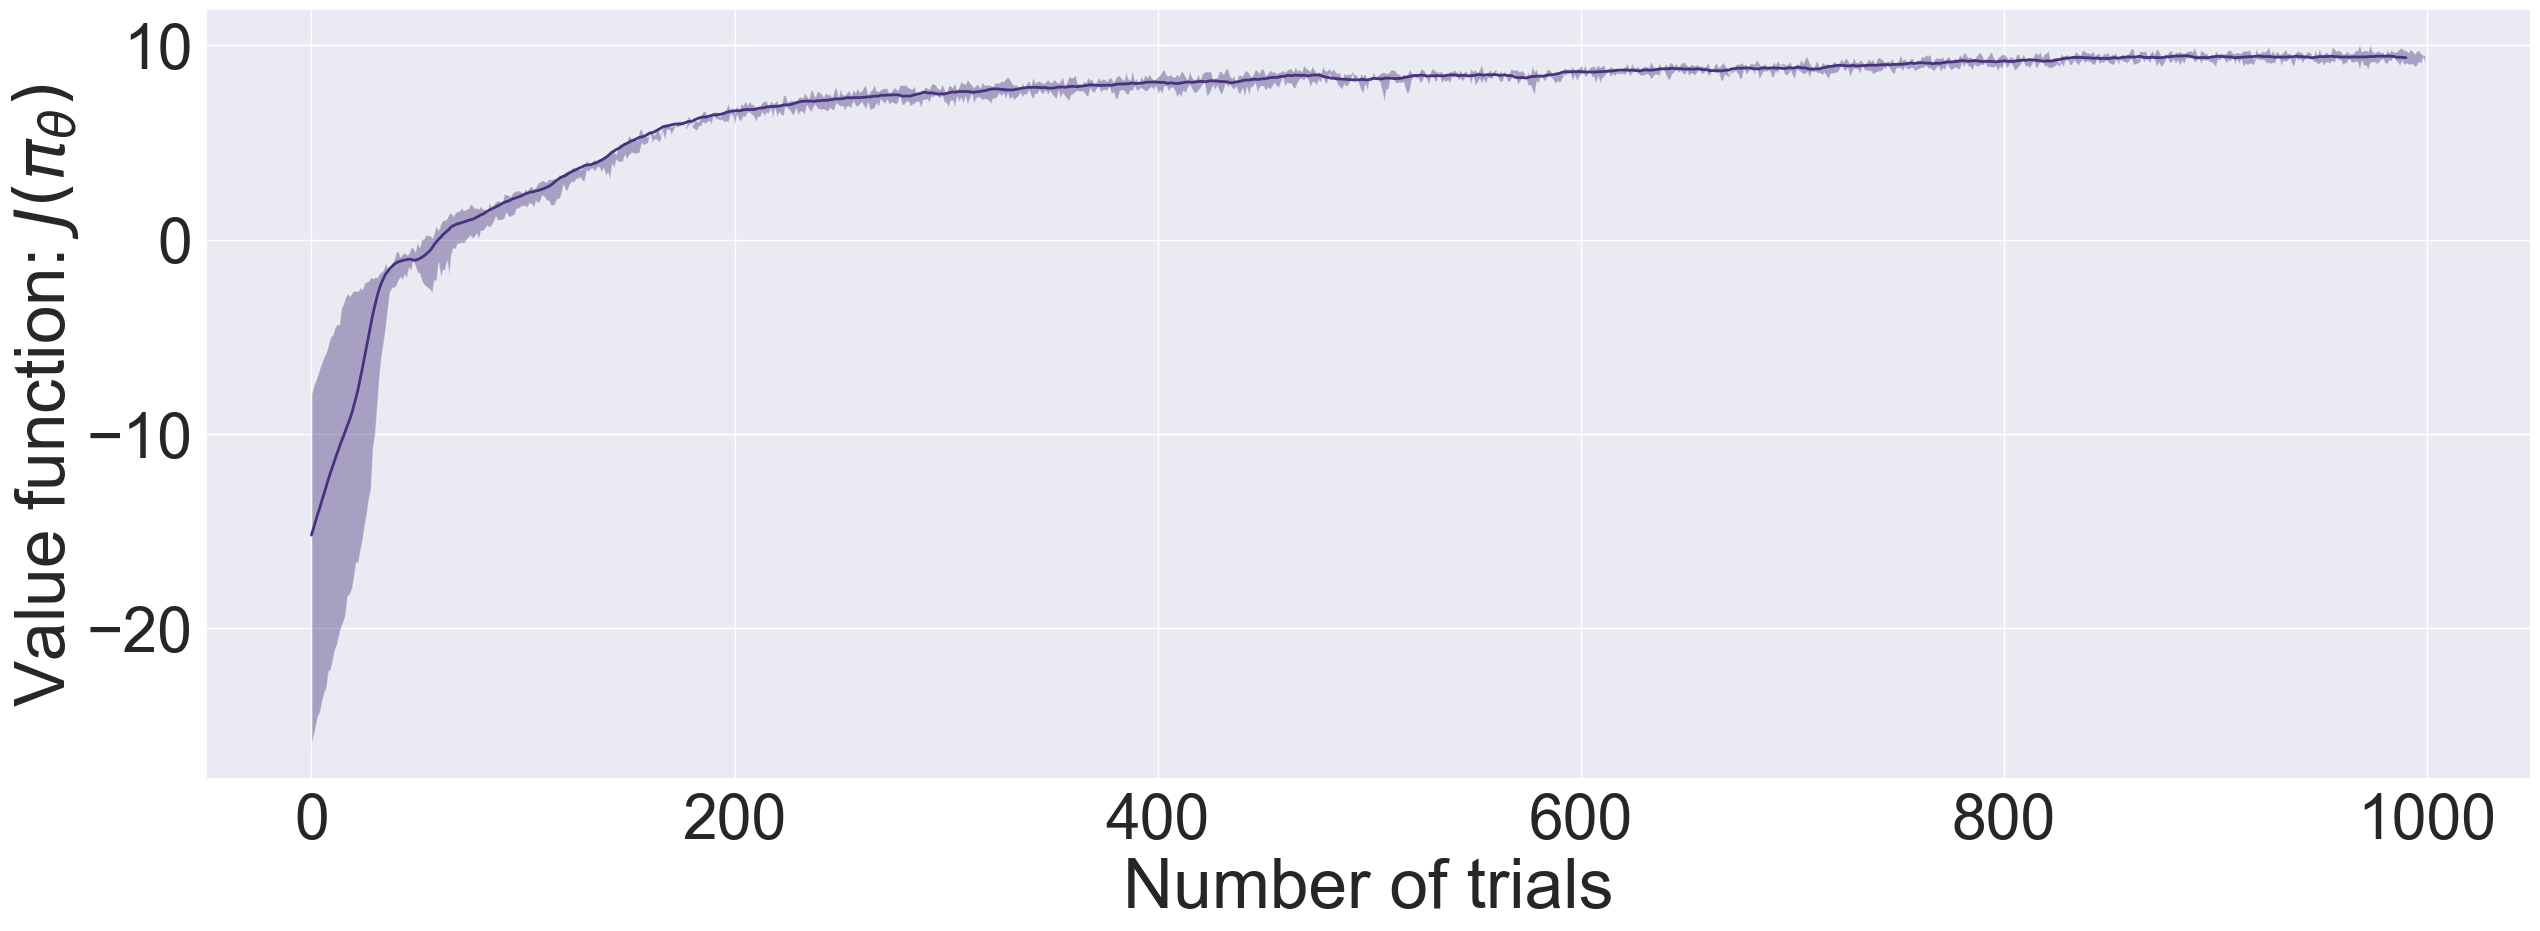

In [17]:
data_new = data[:,:1000]
mean = np.mean(data_new, axis=0)
#smooth the curve
mean_smooth = np.convolve(mean, np.ones(10)/10, mode='valid')
var = np.var(data_new, axis=0)
std_dev = np.std(data_new, axis=0)
#std_dev = np.convolve(std_dev, np.ones(10)/10, mode='valid')

# mean variance curve
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(mean_smooth, linewidth=2)
#ax.fill_between(range(len(mean_smooth)), mean_smooth-std_dev, mean_smooth+mean_smooth, alpha=0.4)
ax.fill_between(range(len(mean)), mean-std_dev, mean+std_dev, alpha=0.4)
#set x label
ax.set_xlabel('Number of trials', fontsize=50)
ax.set_ylabel('Value function: $J(\pi_\\theta)$', fontsize=50)
#set xticks and yticks size
ax.tick_params(axis='x', labelsize=45)
ax.tick_params(axis='y', labelsize=45)
plt.savefig('value_curve.svg', format='svg', bbox_inches='tight')
plt.show()

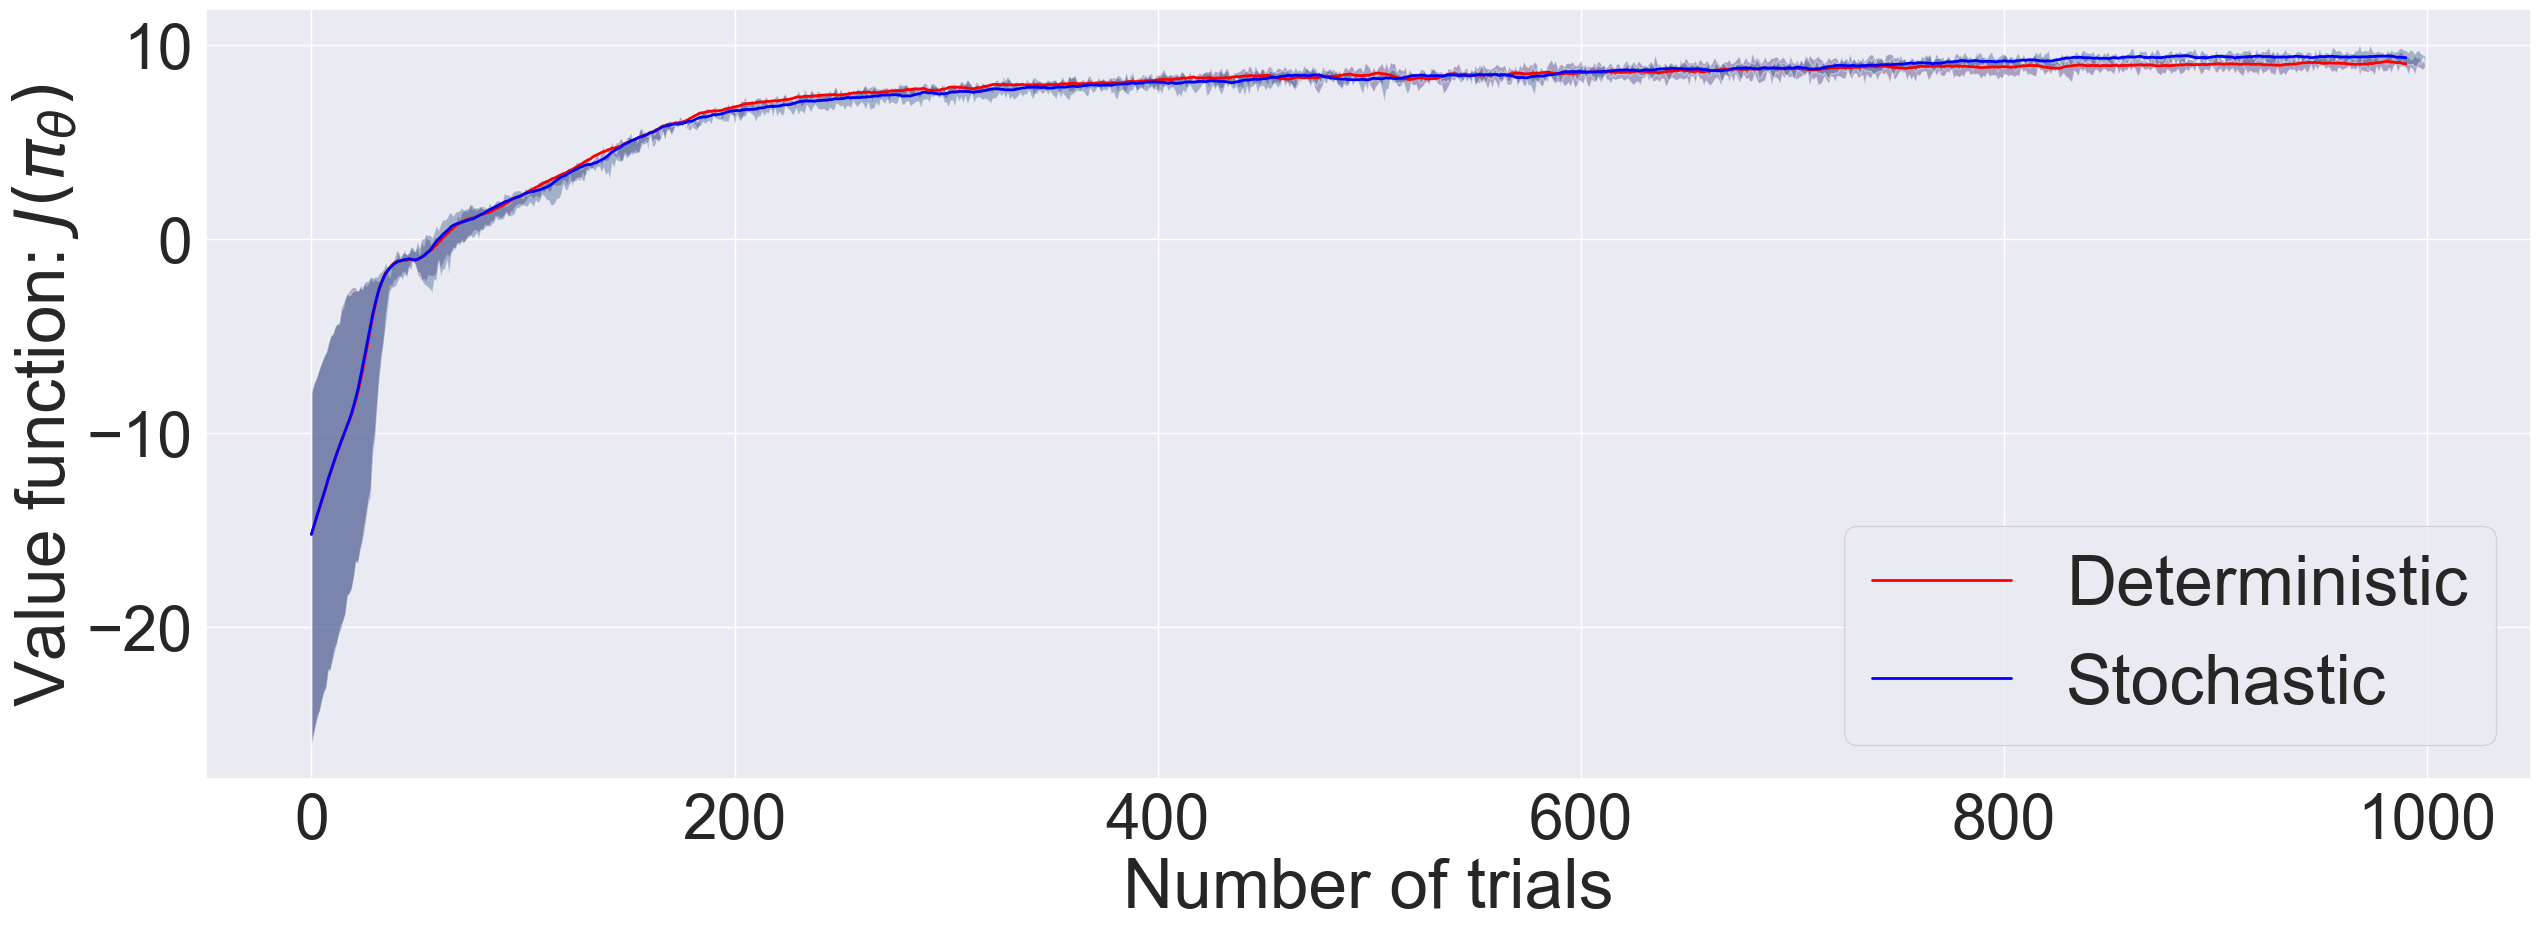

In [23]:
data_d = np.load('values_deterministic.npy')
data_new_d = data_d[:,:1000]
mean_d = np.mean(data_new_d, axis=0)
mean_smooth_d = np.convolve(mean_d, np.ones(10)/10, mode='valid')
var_d = np.var(data_new_d, axis=0)
std_dev_d = np.std(data_new_d, axis=0)
#std_dev = np.convolve(std_dev, np.ones(10)/10, mode='valid')

data_s = np.load('values_stochastic.npy')
data_new_s = data_s[:,:1000]
mean_s = np.mean(data_new_s, axis=0)
mean_smooth_s = np.convolve(mean_s, np.ones(10)/10, mode='valid')
var_s = np.var(data_new_s, axis=0)
std_dev_s = np.std(data_new_s, axis=0)

# mean variance curve
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(mean_smooth_d, linewidth=2, label="Deterministic", color='red')
ax.fill_between(range(len(mean_d)), mean_d-std_dev_d, mean_d+std_dev_d, alpha=0.4)
ax.plot(mean_smooth_s, linewidth=2, label="Stochastic", color='blue')
ax.fill_between(range(len(mean_s)), mean_s-std_dev_s, mean_s+std_dev_s, alpha=0.4)
#set x label
ax.set_xlabel('Number of trials', fontsize=50)
ax.set_ylabel('Value function: $J(\pi_\\theta)$', fontsize=50)
#set xticks and yticks size
ax.tick_params(axis='x', labelsize=45)
ax.tick_params(axis='y', labelsize=45)

plt.legend(fontsize=50)
plt.savefig('value_curve_comp.svg', format='svg', bbox_inches='tight')
plt.show()

In [26]:
from main import *
t0 = 0.0
t1 = 40.0
dt = 0.04
def per_initial_state(bf, init_state, key):
    solver = EulerHeun()
    obs = jnp.array([jnp.sin(init_state[0][0]), jnp.cos(init_state[0][0]), init_state[0][1],
                     jnp.sin(init_state[0][2]), jnp.cos(init_state[0][2]), init_state[0][3],
                     init_state[1][0], init_state[1][1], init_state[2][0]])
    z_init = bf.produce_z(obs)
    init_state_array = jnp.concatenate([init_state[0], z_init, init_state[1], init_state[2]], axis=0)
    t0 = 0.0
    t1 = 40.0
    dt0 = 0.04
    ts = jnp.linspace(t0,t1,1000)
    args = None
    saveat = SaveAt(ts = ts, t1 = True)
    brownian_term = VirtualBrownianTree(t0, t1, tol=1e-3, shape = (2,), key = key)
    system = MultiTerm(ODETerm(bf.term), ControlTerm(bf.diffusion, brownian_term))
    sol = diffeqsolve(system,
                        solver,
                        t0,
                        t1,
                        dt0,
                        init_state_array,
                        args,
                        saveat=saveat, 
                        max_steps=1000000
                        )
    return sol.ys
jit_per_initial_state = jax.jit(per_initial_state)

In [31]:
system = BigField(seed=11,num_neurons=40)
init_state  = system.reset(batch_size=5)
key, *keys = jax.random.split(system.random_machine.produce_key(),6)
keys = jnp.array(keys)
bf_deteministic = eqx.tree_deserialise_leaves('deterministic.eqx', system)
bf_stochastic = eqx.tree_deserialise_leaves('./models_debug/epoch_925seed_2val10.13978811798258.eqx', system)

In [32]:
sol_ys = jax.vmap(jit_per_initial_state, in_axes=(None,0,0))(bf_deteministic, init_state, keys)
xs, zs ,ss, es = (sol_ys[:,:,:4], sol_ys[:,:,4:4+bf_deteministic.num_neurons], sol_ys[:,:,4+bf_deteministic.num_neurons:4+bf_deteministic.num_neurons+2], sol_ys[:,:,4+bf_deteministic.num_neurons+2:4+bf_deteministic.num_neurons+3])
# MSE error for the distance to the target when the agent is at the target

es (5, 1001, 1)
std_dev_es (1001,)


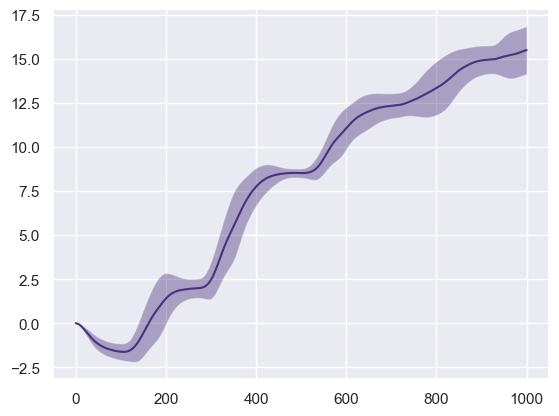

In [42]:
print("es", es.shape)
mean_es = np.mean(es, axis=0)
std_dev_es = np.std(es, axis=0)
mean_es = np.reshape(mean_es, (1001,))
std_dev_es = np.reshape(std_dev_es, (1001,))
print("std_dev_es", std_dev_es.shape)
plt.plot(mean_es)
plt.fill_between(range(len(mean_es)), mean_es-std_dev_es, mean_es+std_dev_es, alpha=0.4)
plt.show()

In [35]:
sol_ys_s = jax.vmap(jit_per_initial_state, in_axes=(None,0,0))(bf_stochastic, init_state, keys)
xs_s, zs_s ,ss_s, es_s = (sol_ys_s[:,:,:4], sol_ys_s[:,:,4:4+bf_stochastic.num_neurons], sol_ys_s[:,:,4+bf_stochastic.num_neurons:4+bf_stochastic.num_neurons+2], sol_ys_s[:,:,4+bf_stochastic.num_neurons+2:4+bf_stochastic.num_neurons+3])

es (5, 1001, 1)


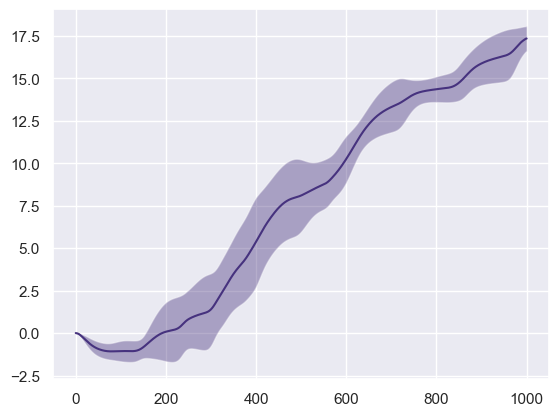

In [43]:
print("es", es_s.shape)
mean_es_s = jnp.mean(es_s, axis=0)
std_dev_es_s = np.std(es_s, axis=0)
mean_es_s = np.reshape(mean_es_s, (1001,))
std_dev_es_s = np.reshape(std_dev_es_s, (1001,))
plt.plot(mean_es_s)
plt.fill_between(range(len(mean_es_s)), mean_es_s-std_dev_es_s, mean_es_s+std_dev_es_s, alpha=0.4)
plt.show()

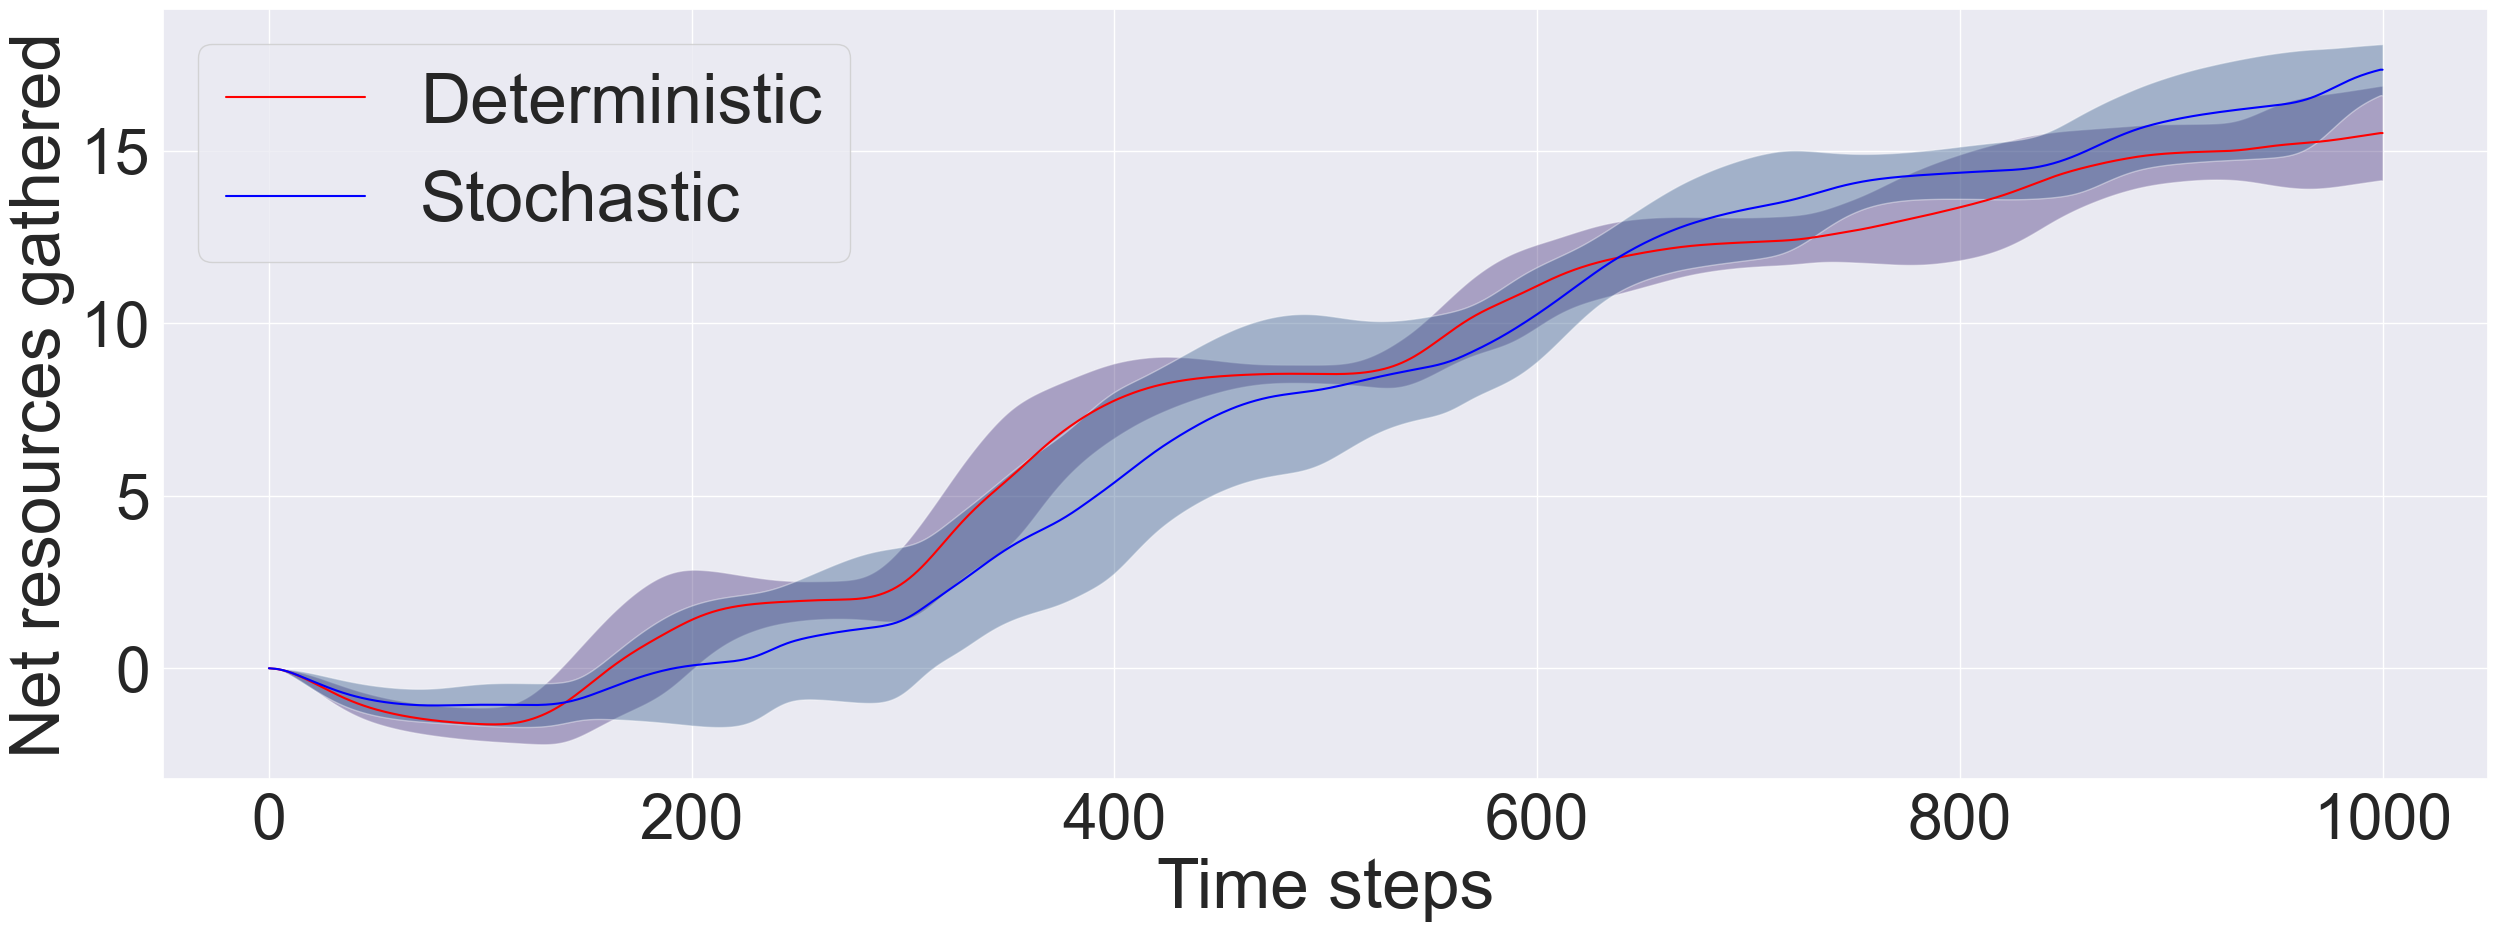

In [47]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(mean_es, label="Deterministic", color='red')
ax.fill_between(range(len(mean_es)), mean_es-std_dev_es, mean_es+std_dev_es, alpha=0.4)
ax.plot(mean_es_s, label="Stochastic", color='blue')
ax.fill_between(range(len(mean_es_s)), mean_es_s-std_dev_es_s, mean_es_s+std_dev_es_s, alpha=0.4)
ax.set_xlabel('Time steps', fontsize=50)
ax.set_ylabel('Net resources gathered', fontsize=50)
ax.tick_params(axis='x', labelsize=45)
ax.tick_params(axis='y', labelsize=45)
ax.legend(fontsize=50)
plt.savefig('value_comparison.svg', format='svg', bbox_inches='tight')
plt.show()